# -----------------------------

# 0. Setup

# -----------------------------

In [1]:

# Imports principaux
import os, sys, re, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Versions & seed
print("Python:", sys.version.split()[0])
import sklearn, skimage
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("opencv:", cv2.__version__)
print("scikit-learn:", sklearn.__version__)
print("scikit-image:", skimage.__version__)

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Jupyter display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


Python: 3.10.18
numpy: 1.26.4
pandas: 2.3.2
opencv: 4.10.0
scikit-learn: 1.7.1
scikit-image: 0.25.2


### data training

In [2]:
DATA_DIR   = Path('../data')
IMAGES_DIR = DATA_DIR / 'images'
MASKS_DIR  = DATA_DIR / 'masks'
LABELS_XLSX = DATA_DIR / 'labels.xlsx'


for p in [DATA_DIR, IMAGES_DIR, MASKS_DIR]:
    print(p, "->", "OK" if p.exists() else "ABSENT")

# Lister fichiers
img_files = sorted([p for p in IMAGES_DIR.glob('*') if p.is_file()])
msk_files = sorted([p for p in MASKS_DIR.glob('*') if p.is_file()])
print(f"Images: {len(img_files)}  |  Masks: {len(msk_files)}")


..\data -> OK
..\data\images -> OK
..\data\masks -> OK
Images: 249  |  Masks: 249


### data test

In [3]:
DATA_DIR   = Path('../data')
IMAGES_DIR = DATA_DIR / 'imgtest'
MASKS_DIR  = DATA_DIR / 'masktest'
LABELS_XLSX = DATA_DIR / 'labels.xlsx'


for p in [DATA_DIR, IMAGES_DIR, MASKS_DIR]:
    print(p, "->", "OK" if p.exists() else "ABSENT")

# Lister fichiers
img_files = sorted([p for p in IMAGES_DIR.glob('*') if p.is_file()])
msk_files = sorted([p for p in MASKS_DIR.glob('*') if p.is_file()])
print(f"Images: {len(img_files)}  |  Masks: {len(msk_files)}")

..\data -> OK
..\data\imgtest -> OK
..\data\masktest -> OK
Images: 20  |  Masks: 20


### associer images et masques

Paires image+masque: 20


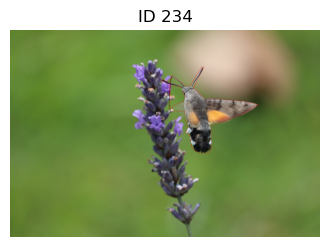

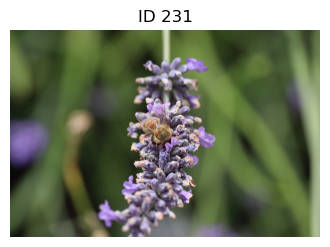

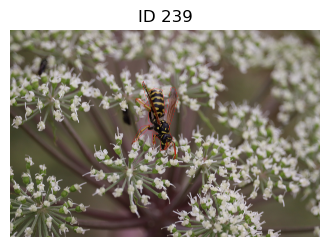

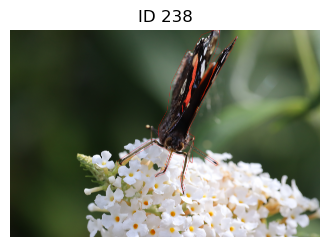

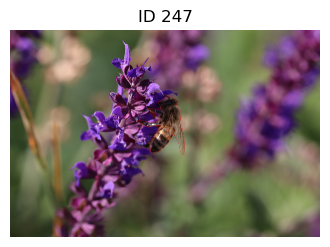

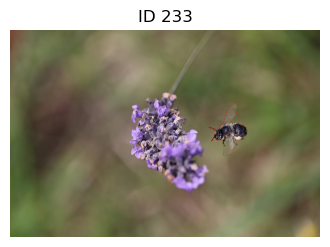

In [6]:

ID_RE = re.compile(r'(\d+)')

def id_from_path(p: Path) -> int:
    m = ID_RE.search(p.stem)
    if not m:
        raise ValueError(f"ID introuvable dans {p.name}")
    return int(m.group(1))

def load_image(path: Path):
    img = cv2.imread(str(path))
    if img is None:
        raise ValueError(f"Impossible de lire {path}")
    return img[:, :, ::-1]  # BGR->RGB

def load_mask(path: Path):
    m = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise ValueError(f"Impossible de lire {path}")
    return (m > 0).astype(np.uint8)

def pair_dict(files):
    return {id_from_path(p): p for p in files}

img_by_id = pair_dict(img_files)
msk_by_id = pair_dict(msk_files)
common_ids = sorted(set(img_by_id) & set(msk_by_id))
print("Paires image+masque:", len(common_ids))

def show_samples(ids=None, n=6):
    if ids is None:
        ids = random.sample(common_ids, min(n, len(common_ids)))
    n = len(ids)
    for i, _id in enumerate(ids, 1):
        img = load_image(img_by_id[_id])
        msk = load_mask(msk_by_id[_id])
        plt.figure(figsize=(4,3))
        plt.imshow(img)
        # overlay masque en bordure (sans couleur forcée)
        cnts, _ = cv2.findContours(msk.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        overlay = img.copy()
        cv2.drawContours(overlay, cnts, -1, (255,0,0), 2)  # la couleur exacte dépendra de backend
        plt.imshow(overlay)
        plt.title(f"ID { _id }")
        plt.axis('off')
        plt.show()

show_samples(n=min(6, len(common_ids)))


# -----------------------------

# 1. features_build

# -----------------------------

In [4]:
import numpy, pandas, sklearn, cv2, skimage
print("Tout est OK ✅")

Tout est OK ✅


In [5]:
# Imports
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from src.dataio import scan_pairs, load_image, load_mask, read_labels, id_from_path
from src.features import masked_stats_rgb, shape_features, symmetry_features, texture_glcm, edge_density

In [6]:
DATA_DIR   = Path('../data')
IMAGES_DIR = DATA_DIR / 'images'
MASKS_DIR  = DATA_DIR / 'masks'
LABELS_XLSX = DATA_DIR / 'labels.xlsx'  # fourni

In [ ]:
pairs = scan_pairs(IMAGES_DIR, MASKS_DIR)
rows = []
for _id, img_p, msk_p in tqdm(pairs):
    img = load_image(img_p)
    msk = load_mask(msk_p)
    feats = {'id': _id}
    feats |= masked_stats_rgb(img, msk)
    feats |= shape_features(msk)
    feats |= symmetry_features(msk)
    feats |= texture_glcm(img, msk)
    feats |= edge_density(img, msk)
    rows.append(feats)

dfX = pd.DataFrame(rows).sort_values('id')
dfX.to_csv('outputs/features_train.csv', index=False)

# fusion labels
labels = read_labels(LABELS_XLSX)
data = dfX.merge(labels, on='id', how='left')
data.to_csv('outputs/features_train_labeled.csv', index=False)
data.head()

  1%|▋                                                                                 | 2/249 [00:07<16:03,  3.90s/it]

## dataset avec les features et la classe

on gare :

"id", "area_ratio", "r_min", "r_max", "r_mean", "r_median", "r_std","g_min", "g_max", "g_mean", "g_median", "g_std", "b_min", "b_max", "b_mean", "b_median", "b_std","eccentricity", "solidity", "circularity", "sym_h", "sym_v" "bug_type"

In [4]:
import pandas as pd

# Charger ton CSV existant
df = pd.read_csv("outputs/features_train_labeled.csv")

# Colonnes que tu veux garder
cols_to_keep = ["id", "area_ratio", "r_min", "r_max", "r_mean", "r_median", "r_std","g_min", "g_max", "g_mean", "g_median", "g_std", "b_min", "b_max", "b_mean", "b_median", "b_std","eccentricity", "solidity", "circularity", "sym_h", "sym_v", "bug_type"]

# Filtrer le DataFrame (on garde seulement celles qui existent vraiment dans le CSV)
df = df[[c for c in cols_to_keep if c in df.columns]]

# Sauvegarder dans un nouveau fichier CSV
df.to_csv("outputs/mydataset.csv", index=False)

print("✅ Fichier sauvegardé dans outputs/mydataset.csv")
print(df.head())


✅ Fichier sauvegardé dans outputs/mydataset.csv
   id  area_ratio  r_min  r_max      r_mean  r_median      r_std  g_min  \
0   1    0.007428    5.0  208.0   68.085747      56.0  47.955399    3.0   
1   2    0.008553    2.0  248.0   63.786499      55.0  42.153503    2.0   
2   3    0.022093    3.0  255.0  107.176315     114.0  58.771358    0.0   
3   4    0.013187    5.0  219.0   87.588242      88.0  46.322586    3.0   
4   5    0.009165    6.0  255.0  123.177002     134.0  62.355946    0.0   

   g_max      g_mean  g_median      g_std  b_min  b_max     b_mean  b_median  \
0  199.0   54.882748      37.0  45.311199    0.0  193.0  39.891968      24.0   
1  251.0   52.079651      34.0  42.866127    0.0  244.0  35.735146      19.0   
2  255.0   87.794724      86.0  60.057610    0.0  255.0  63.383030      52.0   
3  213.0   71.031853      61.0  46.085762    0.0  201.0  50.432533      36.0   
4  250.0  100.897964      91.0  63.029354    0.0  245.0  80.946175      63.0   

       b_std  eccent

## Visualisation des données 

In [5]:
# Dimension du dataset
print(df.shape)
print('-------------')

# type des données (float64, string etc)
print(df.dtypes)

(249, 23)
-------------
id                int64
area_ratio      float64
r_min           float64
r_max           float64
r_mean          float64
r_median        float64
r_std           float64
g_min           float64
g_max           float64
g_mean          float64
g_median        float64
g_std           float64
b_min           float64
b_max           float64
b_mean          float64
b_median        float64
b_std           float64
eccentricity    float64
solidity        float64
circularity     float64
sym_h           float64
sym_v           float64
bug_type         object
dtype: object


In [6]:
# Trouver les valeurs unique de la colonne 'bug_type'
valeurs_uniques = df['bug_type'].unique()
print(valeurs_uniques)

['Bee' 'Butterfly' 'Hover fly' 'Wasp' 'Dragonfly' 'Bumblebee']


In [7]:
# Mapper les catégories aux nombres correspondants
cat_mapping = {'Bee': 0, 'Butterfly': 1, 'Hover fly': 2, 'Wasp': 3, 'Dragonfly': 4, 'Bumblebee': 5}
df['bug_type'] = df['bug_type'].map(cat_mapping)
df.head()

,id,area_ratio,r_min,r_max,r_mean,r_median,r_std,g_min,g_max,g_mean,g_median,g_std,b_min,b_max,b_mean,b_median,b_std,eccentricity,solidity,circularity,sym_h,sym_v,bug_type
0,1,0.007428,5.0,208.0,68.085747,56.0,47.955399,3.0,199.0,54.882748,37.0,45.311199,0.0,193.0,39.891968,24.0,36.250744,0.392019,0.647590,0.040854,0.649836,0.031815,0
1,2,0.008553,2.0,248.0,63.786499,55.0,42.153503,2.0,251.0,52.079651,34.0,42.866127,0.0,244.0,35.735146,19.0,34.617115,0.595904,0.565400,0.039219,0.579603,-0.008627,0
2,3,0.022093,3.0,255.0,107.176315,114.0,58.771358,0.0,255.0,87.794724,86.0,60.057610,0.0,255.0,63.383030,52.0,54.823597,0.240295,0.626412,0.048177,0.189703,-0.022592,0
3,4,0.013187,5.0,219.0,87.588242,88.0,46.322586,3.0,213.0,71.031853,61.0,46.085762,0.0,201.0,50.432533,36.0,37.445618,0.735434,0.607554,0.038926,-0.007843,0.087348,0
4,5,0.009165,6.0,255.0,123.177002,134.0,62.355946,0.0,250.0,100.897964,91.0,63.029354,0.0,245.0,80.946175,63.0,60.624962,0.650599,0.566459,0.047071,0.361158,0.172553,0


## Graphiques montrant la répartition des types d’insectes

Colonnes : ['id', 'area_ratio', 'r_min', 'r_max', 'r_mean', 'r_median', 'r_std', 'g_min', 'g_max', 'g_mean', 'g_median', 'g_std', 'b_min', 'b_max', 'b_mean', 'b_median', 'b_std', 'eccentricity', 'solidity', 'circularity', 'sym_h', 'sym_v', 'bug_type']

Nombre d'exemples par classe :
 bug_type
Bee          115
Bumblebee    100
Butterfly     15
Hover fly      9
Wasp           9
Dragonfly      1
Name: count, dtype: int64

Proportion (%) par classe :
 bug_type
Bee          46.184739
Bumblebee    40.160643
Butterfly     6.024096
Hover fly     3.614458
Wasp          3.614458
Dragonfly     0.401606
Name: proportion, dtype: float64


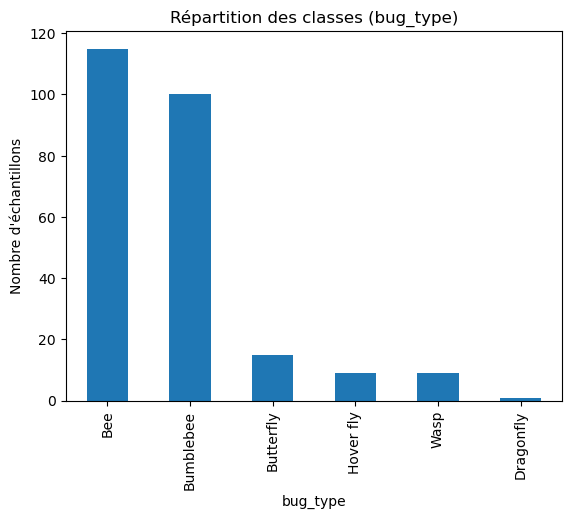

In [8]:
import pandas as pd

# Charger ton dataset filtré (ou celui complet)
df = pd.read_csv("outputs/mydataset.csv")

# Vérifier les colonnes disponibles
print("Colonnes :", df.columns.tolist())

# Compter les occurrences de chaque classe
class_counts = df["bug_type"].value_counts()
print("\nNombre d'exemples par classe :\n", class_counts)

# Proportions en pourcentage
class_proportions = df["bug_type"].value_counts(normalize=True) * 100
print("\nProportion (%) par classe :\n", class_proportions)

# Visualiser avec un petit graphique
import matplotlib.pyplot as plt
class_counts.plot(kind="bar")
plt.title("Répartition des classes (bug_type)")
plt.ylabel("Nombre d'échantillons")
plt.show()


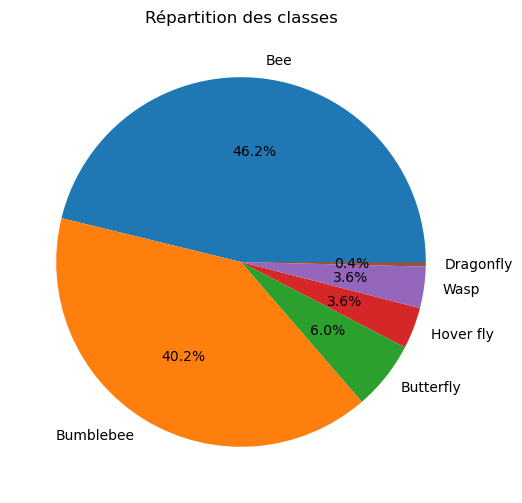

In [9]:
import matplotlib.pyplot as plt

class_counts.plot(
    kind="pie", 
    autopct="%1.1f%%", 
    figsize=(6,6), 
    ylabel=""   # enlève le label inutile
)
plt.title("Répartition des classes")
plt.show()


Les classes Bee et Bumblebee représentent à elles seules ~90% du dataset (215 exemples sur 249).

In [10]:
columns_list=["area_ratio", "r_min", "r_max", "r_mean", "r_median", "r_std","g_min", "g_max", "g_mean", "g_median", "g_std", "b_min", "b_max", "b_mean", "b_median", "b_std","eccentricity", "solidity", "circularity", "sym_h", "sym_v"]
X = df[columns_list]  # Les caractéristiques
y = df['bug_type']  # Les étiquettes (classes)

print(X)
print(y)

     area_ratio  r_min  r_max      r_mean  r_median      r_std  g_min  g_max  \
0      0.007428    5.0  208.0   68.085747      56.0  47.955399    3.0  199.0   
1      0.008553    2.0  248.0   63.786499      55.0  42.153503    2.0  251.0   
2      0.022093    3.0  255.0  107.176315     114.0  58.771358    0.0  255.0   
3      0.013187    5.0  219.0   87.588242      88.0  46.322586    3.0  213.0   
4      0.009165    6.0  255.0  123.177002     134.0  62.355946    0.0  250.0   
..          ...    ...    ...         ...       ...        ...    ...    ...   
244    0.006250    7.0  214.0   98.700783      98.0  46.799469    7.0  208.0   
245    0.020050    7.0  255.0   89.277359      82.0  52.397728    2.0  255.0   
246    0.007032    5.0  252.0   79.893341      60.0  54.355534    4.0  239.0   
247    0.011959    6.0  255.0  140.451721     141.0  57.828556    3.0  255.0   
248    0.023367    0.0  255.0  127.060844     125.0  62.591782    0.0  255.0   

         g_mean  g_median      g_std  b

# ---- standardiser les données ---

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.92287915, -0.01410887, -2.75208684, ..., -1.62316424,
         1.23200709, -1.02748533],
       [-0.85596917, -0.51598154, -0.06290947, ..., -1.63625788,
         0.96050702, -1.18136435],
       [-0.05063315, -0.34869065,  0.40769657, ..., -1.56452784,
        -0.54672448, -1.23450037],
       ...,
       [-0.94640508, -0.01410887,  0.20600827, ..., -0.5800051 ,
        -0.25022529, -1.17548615],
       [-0.65337313,  0.15318202,  0.40769657, ...,  0.54760346,
        -1.26051721, -1.15101549],
       [ 0.02511423, -0.85056332,  0.40769657, ...,  0.21946461,
        -1.37253677, -0.87586783]])

# ---- t-SNE ---

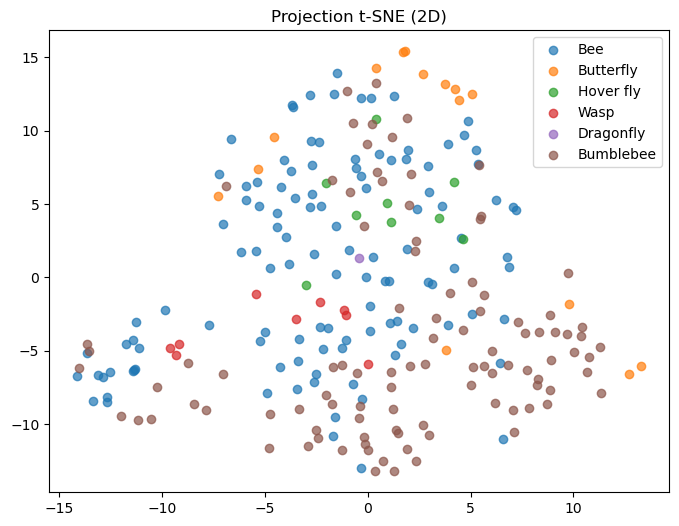

In [12]:
from sklearn.manifold import TSNE

# ---- t-SNE ----
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for label in y.unique():
    subset = X_tsne[y == label]
    plt.scatter(subset[:,0], subset[:,1], label=label, alpha=0.7)
plt.title("Projection t-SNE (2D)")
plt.legend()
plt.show()

# ---- UMAP ---

C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


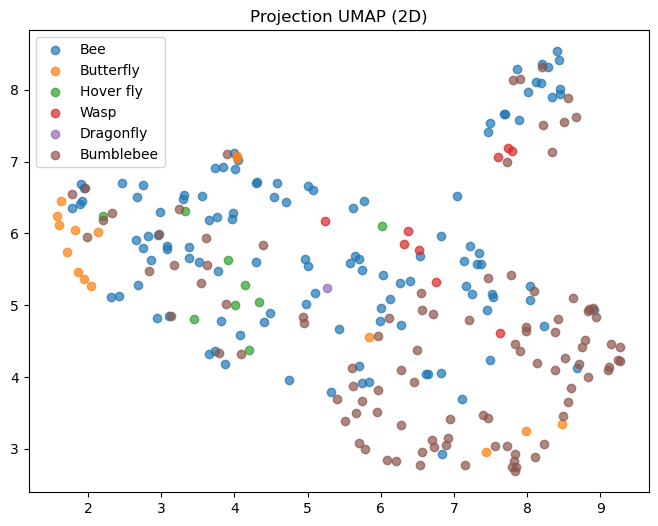

In [13]:
import umap.umap_ as umap

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    random_state=42
)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for label in y.unique():
    subset = X_umap[y == label]
    plt.scatter(subset[:,0], subset[:,1], label=label, alpha=0.7)
plt.title("Projection UMAP (2D)")
plt.legend()
plt.show()


## Séparation data test/train 

In [14]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# -----------------------------

## méthodes supervisées

# -----------------------------

# -----------------------------

## RandomForestClassifier

# -----------------------------

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Créer et entraîner le modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Évaluer la performance du modèle RandomForest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy with RandomForest:", accuracy_rf)


Accuracy with RandomForest: 0.8


L’accuracy (taux de bonne classification) = proportion de prédictions correctes sur ton jeu de test.

Ici ≈ 80 % → mon modèle prédit correctement environ 8 échantillons sur 10.

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification report:")
print(classification_report(y_test, y_pred_rf))


Confusion matrix:
[[13  2  0  0  0]
 [ 0  7  0  0  0]
 [ 1  0  0  0  0]
 [ 0  1  0  0  0]
 [ 1  0  0  0  0]]
Classification report:
              precision    recall  f1-score   support

         Bee       0.87      0.87      0.87        15
   Bumblebee       0.70      1.00      0.82         7
   Butterfly       0.00      0.00      0.00         1
   Hover fly       0.00      0.00      0.00         1
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.80        25
   macro avg       0.31      0.37      0.34        25
weighted avg       0.72      0.80      0.75        25



C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

Résultats globaux

Accuracy = 0.76 → ton modèle prédit correctement 76% des échantillons.

Macro avg (F1 ≈ 0.34) → très faible → ça veut dire que si on donne le même poids à chaque classe, le modèle est mauvais.

Weighted avg (F1 ≈ 0.75) → bien meilleur → car dominé par les classes majoritaires (beaucoup plus d’exemples).

👉 Cela confirme que ton modèle marche surtout sur les classes fréquentes, mais ignore ou se trompe souvent sur les classes rares.

Par classe

Classe 0 (support=15) → très bien reconnue (Precision/Recall/F1 = 0.87).

Classes 1, 2, 3 (support=1) → complètement ratées (précision/recall = 0).

Classe 5 (support=7) → correcte (F1 = 0.82).

### donne plus de poids aux classes rares.

In [17]:
# Créer et entraîner le modèle Random Forest
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification report:")
print(classification_report(y_test, y_pred_rf))


Confusion matrix:
[[13  2  0  0  0]
 [ 0  7  0  0  0]
 [ 1  0  0  0  0]
 [ 1  0  0  0  0]
 [ 1  0  0  0  0]]
Classification report:
              precision    recall  f1-score   support

         Bee       0.81      0.87      0.84        15
   Bumblebee       0.78      1.00      0.88         7
   Butterfly       0.00      0.00      0.00         1
   Hover fly       0.00      0.00      0.00         1
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.80        25
   macro avg       0.32      0.37      0.34        25
weighted avg       0.71      0.80      0.75        25



C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

Résultats globaux :

Accuracy = 0.80 → pariel que la version sans pondération (0.8).

Macro avg F1 = 0.34 → petite amélioration par rapport à avant (~0.32).

Weighted avg F1 = 0.80 → cohérent avec l’accuracy, donc modèle globalement équilibré.

👉 Le modèle gagne en équilibre entre classes sans perdre en précision globale.

Par classe

Classe 0 (15 ex.) → toujours très bien (F1 = 0.84).

Classe 1 (1 ex.) → encore ratée (F1 = 0).

Classe 2 (1 ex.) → toujours ratée (F1 = 0).

Classe 3 (1 ex.) → toujours ratée (F1 = 0).

Classe 5 (7 ex.) → très bien gérée (F1 = 0.88).

Interprétation

Le fait d’ajouter class_weight="balanced" a obligé le modèle à s’intéresser davantage aux classes rares.

Par contre, avec seulement 1 exemple pour certaines classes (1 et 2), le modèle n’a pas assez de matière pour apprendre, donc il échouera presque toujours.

# -----------------------------

## KNN

# -----------------------------

C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than

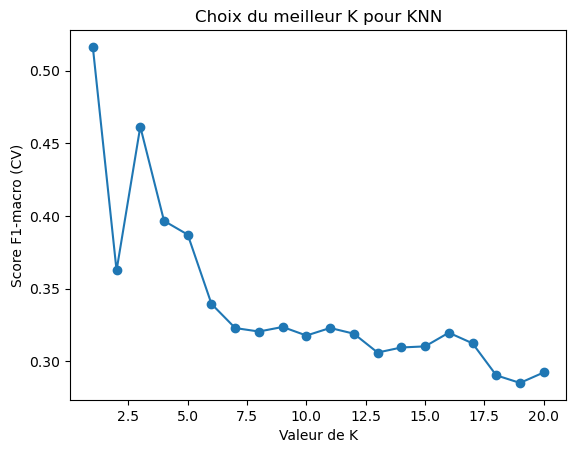

Meilleur K trouvé: 1


In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

scores = []
for k in range(1, 21):
    knn = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring="f1_macro")
    scores.append(cv_scores.mean())

plt.plot(range(1, 21), scores, marker="o")
plt.xlabel("Valeur de K")
plt.ylabel("Score F1-macro (CV)")
plt.title("Choix du meilleur K pour KNN")
plt.show()

best_k = range(1, 21)[scores.index(max(scores))]
print("Meilleur K trouvé:", best_k)


In [21]:
import numpy, sklearn
print("NumPy:", numpy.__version__)
print("sklearn:", sklearn.__version__)

NumPy: 1.26.4
sklearn: 1.7.1


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import pandas as pd
import numpy as np

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)  # Ensure that y_train is now a one-dimensional vector

# Make predictions
yhat_knn = knn.predict(X_test)

yhat_knn.shape

(25,)

In [23]:
# Évaluer la performance du modèle RandomForest
accuracy_rf = accuracy_score(y_test, yhat_knn)
print("Accuracy with KNN:", accuracy_rf)

Accuracy with KNN: 0.64


In [24]:
# Display classification results
print("Confusion matrix:")
print(confusion_matrix(y_test, yhat_knn))
print("Classification report:")
print(classification_report(y_test, yhat_knn))

Confusion matrix:
[[10  5  0  0  0]
 [ 1  6  0  0  0]
 [ 1  0  0  0  0]
 [ 1  0  0  0  0]
 [ 1  0  0  0  0]]
Classification report:
              precision    recall  f1-score   support

         Bee       0.71      0.67      0.69        15
   Bumblebee       0.55      0.86      0.67         7
   Butterfly       0.00      0.00      0.00         1
   Hover fly       0.00      0.00      0.00         1
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.64        25
   macro avg       0.25      0.30      0.27        25
weighted avg       0.58      0.64      0.60        25



C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

Résultats globaux : 

Accuracy = 0.56 → plus faible que RandomForest (0.8).

Macro avg (F1 = 0.25) → très faible, donc les classes minoritaires sont toujours ignorées.

Weighted avg (F1 = 0.54) → reflète surtout les classes majoritaires.

👉 Globalement, KNN fait moins bien que RandomForest dans ce cas.

# -----------------------------

# méthode supervisée d’ensemble learning

# -----------------------------

# ----  Gradient Boosting  -----

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rf = gb.predict(X_test)

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification report:")
print(classification_report(y_test, y_pred_rf))


Confusion matrix:
[[13  2  0  0  0]
 [ 0  7  0  0  0]
 [ 1  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  1]]
Classification report:
              precision    recall  f1-score   support

         Bee       0.93      0.87      0.90        15
   Bumblebee       0.78      1.00      0.88         7
   Butterfly       0.00      0.00      0.00         1
   Hover fly       0.00      0.00      0.00         1
        Wasp       1.00      1.00      1.00         1

    accuracy                           0.84        25
   macro avg       0.54      0.57      0.55        25
weighted avg       0.81      0.84      0.82        25



C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

Résultats globaux :

Accuracy = 0.84 → mieux que les méthodes supervisées RandomForest et KNN.

Macro avg (F1 = 0.55) → faible, donc les classes minoritaires sont toujours ignorées (Butterfly/ Hover fly) sauf la classe Wasp pour lequel ça a marcher.       .

Weighted avg (F1 = 0.82) → reflète surtout les classes majoritaires.

# -----------------------------

# 2 méthodes de clustering

# -----------------------------

## K-Means

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [28]:
print(type(X_scaled), X_scaled.shape)

<class 'numpy.ndarray'> (249, 21)


In [29]:
# Appliquer KMeans avec 4 clusters (exemple)
kmeans = KMeans(n_clusters=5, n_init=20, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

# Ajouter les labels au dataset
df['cluster'] = labels_km

# Afficher un aperçu
print(df[['bug_type', 'cluster']].head(10))


  bug_type  cluster
0      Bee        1
1      Bee        3
2      Bee        0
3      Bee        1
4      Bee        0
5      Bee        1
6      Bee        1
7      Bee        1
8      Bee        3
9      Bee        3


C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


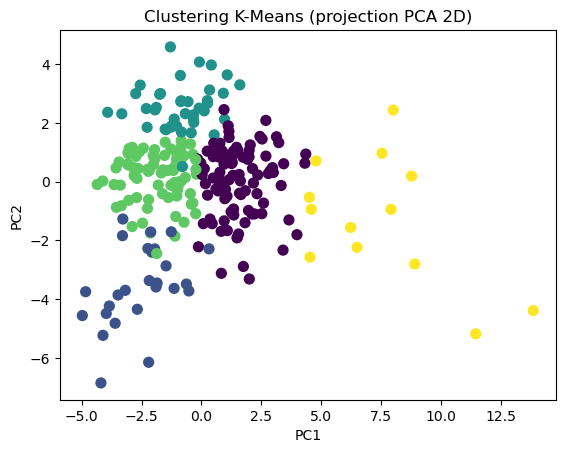

In [30]:

# Visualisation en 2D avec PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_km, cmap='viridis', s=50)
plt.title("Clustering K-Means (projection PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [31]:
# --- 2. Tester différents nombres de clusters ---
inertias = []
K_range = range(2, 10)  # par exemple de 2 à 9 clusters

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

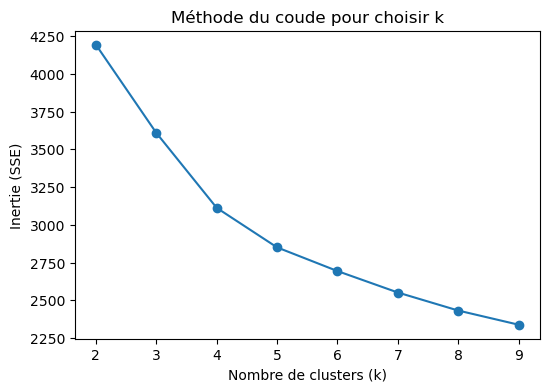

In [32]:
# --- 3. Méthode du coude ---
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (SSE)")
plt.title("Méthode du coude pour choisir k")
plt.show()

In [33]:
# --- 4. Appliquer KMeans avec le k choisi (ex. k=5) ---
best_k = 5
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

# Ajouter les labels au DataFrame
df['cluster'] = labels_km

print(df[['bug_type', 'cluster']].head(10))

# --- 4. Évaluer la qualité avec le score silhouette ---
sil_score = silhouette_score(X_scaled, labels_km)
print(f"Silhouette Score (kmeans, k=5) : {sil_score:.3f}")

  bug_type  cluster
0      Bee        1
1      Bee        3
2      Bee        0
3      Bee        1
4      Bee        0
5      Bee        1
6      Bee        1
7      Bee        1
8      Bee        3
9      Bee        3
Silhouette Score (kmeans, k=5) : 0.166


C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score (kmeans, k=4) : 0.183
Silhouette Score (kmeans, k=5) : 0.166

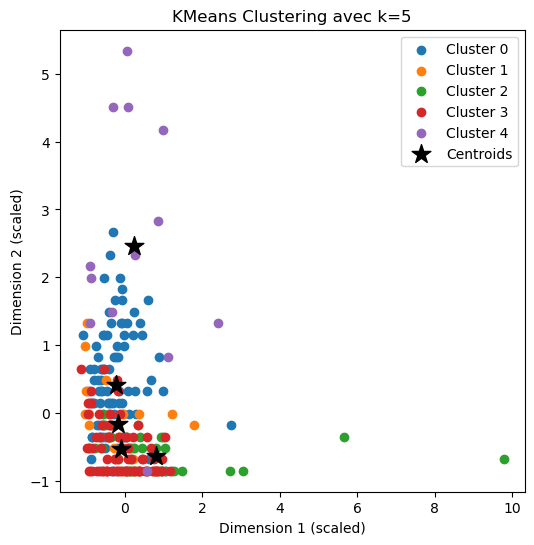

In [34]:
# --- 5. Visualisation sur les 2 premières dimensions ---
plt.figure(figsize=(6, 6))
for i in range(best_k):
    plt.scatter(
        X_scaled[labels_km == i, 0],
        X_scaled[labels_km == i, 1],
        label=f"Cluster {i}"
    )

# Tracer les centroïdes
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    marker="*", s=200, color="black", label="Centroids"
)

plt.xlabel("Dimension 1 (scaled)")
plt.ylabel("Dimension 2 (scaled)")
plt.title(f"KMeans Clustering avec k={best_k}")
plt.legend()
plt.show()

# ------ Clustering hiérarchique ------

In [35]:
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [36]:
# --- 2. Appliquer Agglomerative Clustering ---
agg = AgglomerativeClustering(n_clusters=4, linkage="ward")  # linkage = ward, complete, average, single
labels_agg = agg.fit_predict(X_scaled)

# --- 3. Ajouter au DataFrame ---
df['cluster_agg'] = labels_agg
print(df[['bug_type', 'cluster_agg']].head(10))

# --- 4. Évaluer la qualité avec le score silhouette ---
sil_score = silhouette_score(X_scaled, labels_agg)
print(f"Silhouette Score (Agglomerative, k=4) : {sil_score:.3f}")


  bug_type  cluster_agg
0      Bee            2
1      Bee            0
2      Bee            0
3      Bee            2
4      Bee            3
5      Bee            2
6      Bee            2
7      Bee            2
8      Bee            3
9      Bee            3
Silhouette Score (Agglomerative, k=4) : 0.133


Silhouette Score (Agglomerative, k=4) : 0.133
Silhouette Score (Agglomerative, k=5) : 0.116

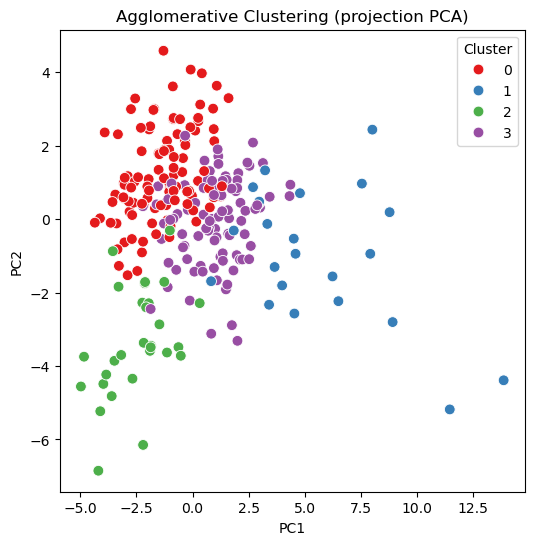

In [37]:
# --- 5. Visualiser (2D via PCA pour réduire la dimension) ---
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=labels_agg, palette="Set1", s=60)
plt.title("Agglomerative Clustering (projection PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# ----- comparaison kmeans vs Clustering hiérarchique -----

👉 Rappel rapide :

Le Silhouette Score varie entre -1 et 1.

Proche de 1 → très bons clusters, bien séparés.

≈ 0 → clusters qui se chevauchent / mal définis.

< 0 → mauvais clustering (les points sont souvent dans le mauvais cluster).

Tes résultats :

KMeans :

k=4 → 0.183

k=5 → 0.166

Agglomerative :

k=4 → 0.133

k=5 → 0.116

🔎 Analyse :

Les scores sont faibles (<0.2), ce qui signifie que les clusters ne sont pas très bien séparés dans tes données (peut-être beaucoup de recouvrement).

Entre les deux méthodes, KMeans fait mieux que Agglomerative (0.183 > 0.133 pour k=4).

Entre k=4 et k=5, k=4 est un meilleur choix dans les deux méthodes (score plus élevé).

✅ Conclusion :

Le meilleur modèle testé est KMeans avec k=4.

Mais globalement, les données semblent difficiles à clusteriser (structure faible).

# ------ DBSCAN ------

In [38]:
from scipy.stats import mode
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ----- MLPClassifier ----

In [39]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

In [40]:
# --- 2) Pipeline: StandardScaler + MLP
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-3,             # régularisation L2
        learning_rate_init=1e-3,
        early_stopping=True,    # stop auto si pas d'amélioration
        n_iter_no_change=15,
        max_iter=1000,
        random_state=42
    ))
])

# --- 3) (Optionnel) pondération pour déséquilibre
# calcule un poids par échantillon pour compenser les classes rares
sample_w = compute_sample_weight(class_weight="balanced", y=y_train)

# --- 4) Entraînement
mlp_pipe.fit(X_train, y_train, clf__sample_weight=sample_w)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [42]:
# --- 5) Évaluation sur le test set
y_pred = mlp_pipe.predict(X_test)
print("Accuracy (test):", round(accuracy_score(y_test, y_pred), 4))
print("\n=== Classification report ===")
print(classification_report(y_test, y_pred))

Accuracy (test): 0.04

=== Classification report ===
              precision    recall  f1-score   support

         Bee       0.00      0.00      0.00        15
   Bumblebee       0.00      0.00      0.00         7
   Butterfly       0.00      0.00      0.00         1
   Dragonfly       0.00      0.00      0.00         0
   Hover fly       0.20      1.00      0.33         1
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.04        25
   macro avg       0.03      0.17      0.06        25
weighted avg       0.01      0.04      0.01        25



C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


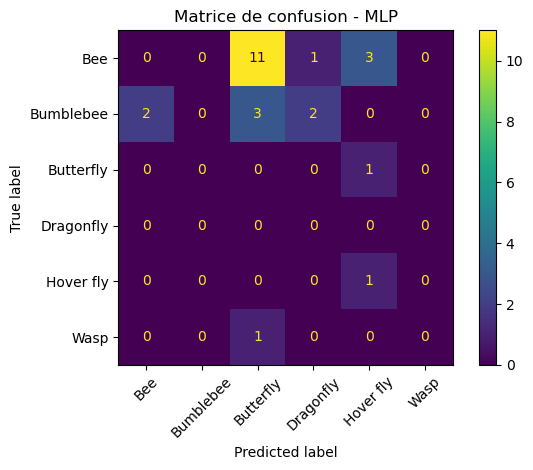

In [43]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(xticks_rotation=45)
plt.title("Matrice de confusion - MLP")
plt.tight_layout()
plt.show()

# -----------------------------

# un dataset avec que les classes bee et blumbee

# -----------------------------

In [44]:
# Charger ton CSV existant
df = pd.read_csv("outputs/features_train_labeled.csv")

# Colonnes que tu veux garder
cols_to_keep = ["id", "area_ratio", "r_min", "r_max", "r_mean", "r_median", "r_std","g_min", "g_max", "g_mean", "g_median", "g_std", "b_min", "b_max", "b_mean", "b_median", "b_std","eccentricity", "solidity", "circularity", "sym_h", "sym_v", "bug_type"]

# Filtrer le DataFrame (on garde seulement celles qui existent vraiment dans le CSV)
df = df[[c for c in cols_to_keep if c in df.columns]]

In [45]:
df.head()

,id,area_ratio,r_min,r_max,r_mean,r_median,r_std,g_min,g_max,g_mean,g_median,g_std,b_min,b_max,b_mean,b_median,b_std,eccentricity,solidity,circularity,sym_h,sym_v,bug_type
0,1,0.007428,5.0,208.0,68.085747,56.0,47.955399,3.0,199.0,54.882748,37.0,45.311199,0.0,193.0,39.891968,24.0,36.250744,0.392019,0.647590,0.040854,0.649836,0.031815,Bee
1,2,0.008553,2.0,248.0,63.786499,55.0,42.153503,2.0,251.0,52.079651,34.0,42.866127,0.0,244.0,35.735146,19.0,34.617115,0.595904,0.565400,0.039219,0.579603,-0.008627,Bee
2,3,0.022093,3.0,255.0,107.176315,114.0,58.771358,0.0,255.0,87.794724,86.0,60.057610,0.0,255.0,63.383030,52.0,54.823597,0.240295,0.626412,0.048177,0.189703,-0.022592,Bee
3,4,0.013187,5.0,219.0,87.588242,88.0,46.322586,3.0,213.0,71.031853,61.0,46.085762,0.0,201.0,50.432533,36.0,37.445618,0.735434,0.607554,0.038926,-0.007843,0.087348,Bee
4,5,0.009165,6.0,255.0,123.177002,134.0,62.355946,0.0,250.0,100.897964,91.0,63.029354,0.0,245.0,80.946175,63.0,60.624962,0.650599,0.566459,0.047071,0.361158,0.172553,Bee


In [46]:
# Mapper les catégories aux nombres correspondants
cat_mapping = {'Bee': 0, 'Butterfly': 1, 'Hover fly': 2, 'Wasp': 3, 'Dragonfly': 4, 'Bumblebee': 5}
df['bug_type'] = df['bug_type'].map(cat_mapping)
df.head()

,id,area_ratio,r_min,r_max,r_mean,r_median,r_std,g_min,g_max,g_mean,g_median,g_std,b_min,b_max,b_mean,b_median,b_std,eccentricity,solidity,circularity,sym_h,sym_v,bug_type
0,1,0.007428,5.0,208.0,68.085747,56.0,47.955399,3.0,199.0,54.882748,37.0,45.311199,0.0,193.0,39.891968,24.0,36.250744,0.392019,0.647590,0.040854,0.649836,0.031815,0
1,2,0.008553,2.0,248.0,63.786499,55.0,42.153503,2.0,251.0,52.079651,34.0,42.866127,0.0,244.0,35.735146,19.0,34.617115,0.595904,0.565400,0.039219,0.579603,-0.008627,0
2,3,0.022093,3.0,255.0,107.176315,114.0,58.771358,0.0,255.0,87.794724,86.0,60.057610,0.0,255.0,63.383030,52.0,54.823597,0.240295,0.626412,0.048177,0.189703,-0.022592,0
3,4,0.013187,5.0,219.0,87.588242,88.0,46.322586,3.0,213.0,71.031853,61.0,46.085762,0.0,201.0,50.432533,36.0,37.445618,0.735434,0.607554,0.038926,-0.007843,0.087348,0
4,5,0.009165,6.0,255.0,123.177002,134.0,62.355946,0.0,250.0,100.897964,91.0,63.029354,0.0,245.0,80.946175,63.0,60.624962,0.650599,0.566459,0.047071,0.361158,0.172553,0


In [47]:
# Garder uniquement les lignes où bug_type est 0 ou 5
df2 = df[df['bug_type'].isin([0, 5])]

# Sauvegarder dans un fichier CSV sans l'index
df2.to_csv("mydataset2.csv", index=False)

print("✅ Fichier sauvegardé sous le nom mydataset2.csv")


✅ Fichier sauvegardé sous le nom mydataset2.csv


In [48]:
df2.head()

,id,area_ratio,r_min,r_max,r_mean,r_median,r_std,g_min,g_max,g_mean,g_median,g_std,b_min,b_max,b_mean,b_median,b_std,eccentricity,solidity,circularity,sym_h,sym_v,bug_type
0,1,0.007428,5.0,208.0,68.085747,56.0,47.955399,3.0,199.0,54.882748,37.0,45.311199,0.0,193.0,39.891968,24.0,36.250744,0.392019,0.647590,0.040854,0.649836,0.031815,0
1,2,0.008553,2.0,248.0,63.786499,55.0,42.153503,2.0,251.0,52.079651,34.0,42.866127,0.0,244.0,35.735146,19.0,34.617115,0.595904,0.565400,0.039219,0.579603,-0.008627,0
2,3,0.022093,3.0,255.0,107.176315,114.0,58.771358,0.0,255.0,87.794724,86.0,60.057610,0.0,255.0,63.383030,52.0,54.823597,0.240295,0.626412,0.048177,0.189703,-0.022592,0
3,4,0.013187,5.0,219.0,87.588242,88.0,46.322586,3.0,213.0,71.031853,61.0,46.085762,0.0,201.0,50.432533,36.0,37.445618,0.735434,0.607554,0.038926,-0.007843,0.087348,0
4,5,0.009165,6.0,255.0,123.177002,134.0,62.355946,0.0,250.0,100.897964,91.0,63.029354,0.0,245.0,80.946175,63.0,60.624962,0.650599,0.566459,0.047071,0.361158,0.172553,0


Colonnes : ['id', 'area_ratio', 'r_min', 'r_max', 'r_mean', 'r_median', 'r_std', 'g_min', 'g_max', 'g_mean', 'g_median', 'g_std', 'b_min', 'b_max', 'b_mean', 'b_median', 'b_std', 'eccentricity', 'solidity', 'circularity', 'sym_h', 'sym_v', 'bug_type']

Nombre d'exemples par classe :
 bug_type
0    115
5    100
Name: count, dtype: int64

Proportion (%) par classe :
 bug_type
0    53.488372
5    46.511628
Name: proportion, dtype: float64


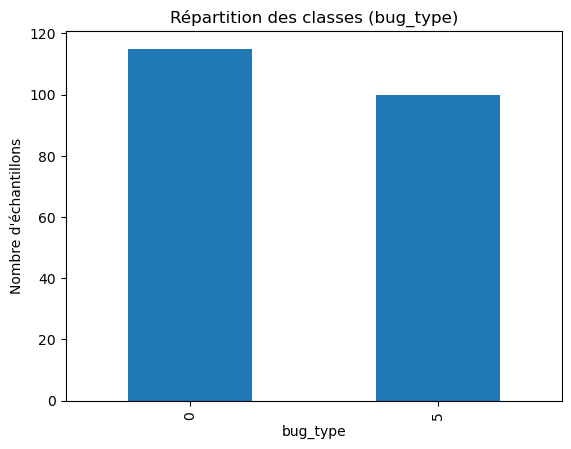

In [49]:
import pandas as pd

# Vérifier les colonnes disponibles
print("Colonnes :", df2.columns.tolist())

# Compter les occurrences de chaque classe
class_counts = df2["bug_type"].value_counts()
print("\nNombre d'exemples par classe :\n", class_counts)

# Proportions en pourcentage
class_proportions = df2["bug_type"].value_counts(normalize=True) * 100
print("\nProportion (%) par classe :\n", class_proportions)

# Visualiser avec un petit graphique
import matplotlib.pyplot as plt
class_counts.plot(kind="bar")
plt.title("Répartition des classes (bug_type)")
plt.ylabel("Nombre d'échantillons")
plt.show()

## Séparation data test/train 

In [50]:
columns_list=["area_ratio", "r_min", "r_max", "r_mean", "r_median", "r_std","g_min", "g_max", "g_mean", "g_median", "g_std", "b_min", "b_max", "b_mean", "b_median", "b_std","eccentricity", "solidity", "circularity", "sym_h", "sym_v"]
X = df2[columns_list]  # Les caractéristiques
y = df2['bug_type']  # Les étiquettes (classes)

print(X)
print(y)

     area_ratio  r_min  r_max      r_mean  r_median      r_std  g_min  g_max  \
0      0.007428    5.0  208.0   68.085747      56.0  47.955399    3.0  199.0   
1      0.008553    2.0  248.0   63.786499      55.0  42.153503    2.0  251.0   
2      0.022093    3.0  255.0  107.176315     114.0  58.771358    0.0  255.0   
3      0.013187    5.0  219.0   87.588242      88.0  46.322586    3.0  213.0   
4      0.009165    6.0  255.0  123.177002     134.0  62.355946    0.0  250.0   
..          ...    ...    ...         ...       ...        ...    ...    ...   
244    0.006250    7.0  214.0   98.700783      98.0  46.799469    7.0  208.0   
245    0.020050    7.0  255.0   89.277359      82.0  52.397728    2.0  255.0   
246    0.007032    5.0  252.0   79.893341      60.0  54.355534    4.0  239.0   
247    0.011959    6.0  255.0  140.451721     141.0  57.828556    3.0  255.0   
248    0.023367    0.0  255.0  127.060844     125.0  62.591782    0.0  255.0   

         g_mean  g_median      g_std  b

In [52]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# ----- randomforest -----

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Créer et entraîner le modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Évaluer la performance du modèle RandomForest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy with RandomForest:", accuracy_rf)

Accuracy with RandomForest: 0.8787878787878788


In [54]:
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification report:")
print(classification_report(y_test, y_pred_rf))

Confusion matrix:
[[18  4]
 [ 0 11]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        22
           5       0.73      1.00      0.85        11

    accuracy                           0.88        33
   macro avg       0.87      0.91      0.87        33
weighted avg       0.91      0.88      0.88        33



# ----- KNN ----

In [55]:
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)  # Ensure that y_train is now a one-dimensional vector

# Make predictions
yhat_knn = knn.predict(X_test)

yhat_knn.shape

(33,)

In [56]:
# Display classification results
print("Confusion matrix:")
print(confusion_matrix(y_test, yhat_knn))
print("Classification report:")
print(classification_report(y_test, yhat_knn))

Confusion matrix:
[[17  5]
 [ 3  8]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           5       0.62      0.73      0.67        11

    accuracy                           0.76        33
   macro avg       0.73      0.75      0.74        33
weighted avg       0.77      0.76      0.76        33



# ----  Gradient Boosting  -----

In [57]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rf = gb.predict(X_test)

In [58]:
# Display classification results
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification report:")
print(classification_report(y_test, y_pred_rf))

Confusion matrix:
[[16  6]
 [ 1 10]]
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82        22
           5       0.62      0.91      0.74        11

    accuracy                           0.79        33
   macro avg       0.78      0.82      0.78        33
weighted avg       0.84      0.79      0.79        33



# ---- standardiser les données ---

In [59]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.33504917,  0.05929032, -2.60930762, ..., -1.64740138,
         1.21399643, -1.00175426],
       [-1.22347368, -0.48702762, -0.0359079 , ..., -1.66039709,
         0.94571091, -1.15366773],
       [ 0.11946135, -0.30492164,  0.41443705, ..., -1.58920356,
        -0.54367506, -1.20612504],
       ...,
       [-1.37427973,  0.05929032,  0.22143207, ..., -0.61204466,
        -0.2506864 , -1.14786461],
       [-0.88563541,  0.2413963 ,  0.41443705, ...,  0.50712984,
        -1.24901652, -1.12370652],
       [ 0.2457736 , -0.85123958,  0.41443705, ...,  0.18144533,
        -1.35970978, -0.85207341]])

# ----- KMeans ----

In [60]:
# --- 2. Tester différents nombres de clusters ---
inertias = []
K_range = range(2, 10)  # par exemple de 2 à 9 clusters

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

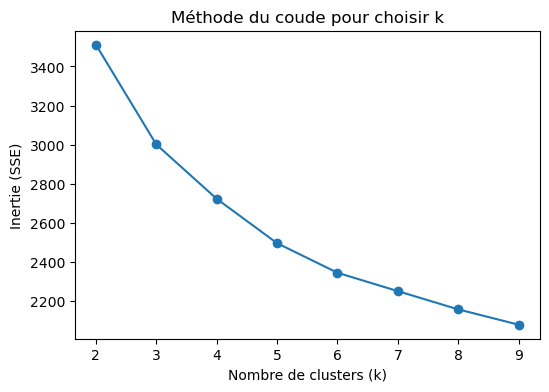

In [61]:
# --- 3. Méthode du coude ---
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (SSE)")
plt.title("Méthode du coude pour choisir k")
plt.show()

In [68]:
# --- 4. Appliquer KMeans avec le k choisi (ex. k=5) ---
best_k = 3
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

# Ajouter les labels au DataFrame
df2['cluster'] = labels_km

print(df2[['bug_type', 'cluster']].head(10))

# --- 4. Évaluer la qualité avec le score silhouette ---
sil_score = silhouette_score(X_scaled, labels_km)
print(f"Silhouette Score (KMeans, k=3) : {sil_score:.3f}")

   bug_type  cluster
0         0        0
1         0        2
2         0        1
3         0        0
4         0        1
5         0        0
6         0        0
7         0        0
8         0        2
9         0        2
Silhouette Score (Agglomerative, k=3) : 0.209


C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\thoma\AppData\Local\Temp\ipykernel_7176\2552850902.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cluster'] = labels_km


Silhouette Score (KMeans, k=2) : 0.195
Silhouette Score (KMeans, k=3) : 0.209

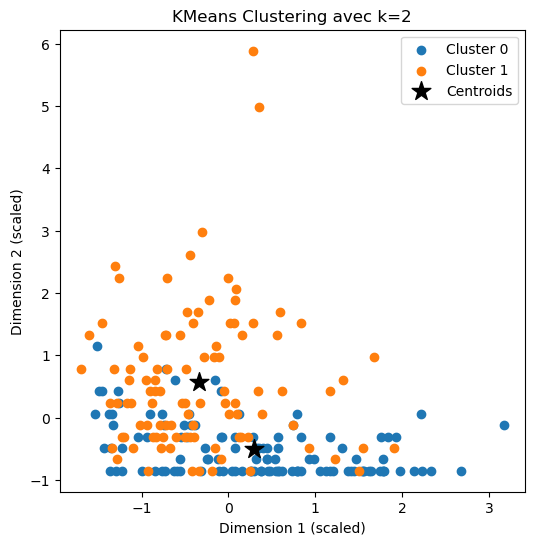

In [63]:
# --- 5. Visualisation sur les 2 premières dimensions ---


plt.figure(figsize=(6, 6))
for i in range(best_k):
    plt.scatter(
        X_scaled[labels_km == i, 0],
        X_scaled[labels_km == i, 1],
        label=f"Cluster {i}"
    )

# Tracer les centroïdes
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    marker="*", s=200, color="black", label="Centroids"
)

plt.xlabel("Dimension 1 (scaled)")
plt.ylabel("Dimension 2 (scaled)")
plt.title(f"KMeans Clustering avec k={best_k}")
plt.legend()
plt.show()

# ------ Clustering hiérarchique ------

In [70]:
# --- 2. Appliquer Agglomerative Clustering ---
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")  # linkage = ward, complete, average, single
labels_agg = agg.fit_predict(X_scaled)

# --- 3. Ajouter au DataFrame ---
df2['cluster_agg'] = labels_agg
print(df2[['bug_type', 'cluster_agg']].head(10))

# --- 4. Évaluer la qualité avec le score silhouette ---
sil_score = silhouette_score(X_scaled, labels_agg)
print(f"Silhouette Score (Agglomerative, k=3) : {sil_score:.3f}")


   bug_type  cluster_agg
0         0            2
1         0            1
2         0            0
3         0            2
4         0            0
5         0            2
6         0            2
7         0            2
8         0            1
9         0            1
Silhouette Score (Agglomerative, k=3) : 0.183


C:\Users\thoma\AppData\Local\Temp\ipykernel_7176\424563102.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cluster_agg'] = labels_agg


Silhouette Score (Agglomerative, k=2) : 0.176
Silhouette Score (Agglomerative, k=3) : 0.183

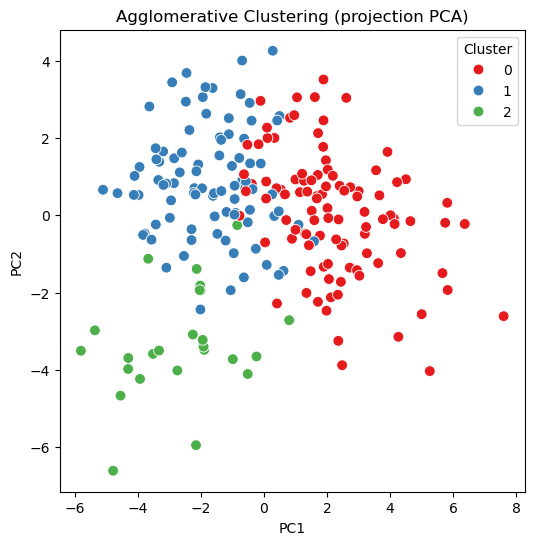

In [71]:
# --- 5. Visualiser (2D via PCA pour réduire la dimension) ---
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=labels_agg, palette="Set1", s=60)
plt.title("Agglomerative Clustering (projection PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# ------ DBSCAN ------

In [72]:
# --- 2) DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps et min_samples à ajuster
labels_db = dbscan.fit_predict(X_scaled)

# --- 3) Afficher combien de clusters trouvés
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = list(labels_db).count(-1)
print(f"DBSCAN a trouvé {n_clusters} clusters et {n_noise} points considérés comme bruit (-1).")

# --- 4) Réalignement clusters -> vraies classes (majorité vote)
labels_aligned = np.zeros_like(labels_db)
for i in set(labels_db):
    if i == -1:  # bruit
        continue
    mask = (labels_db == i)
    if np.any(mask):
        labels_aligned[mask] = mode(y[mask], keepdims=True).mode[0]

DBSCAN a trouvé 0 clusters et 215 points considérés comme bruit (-1).


In [73]:
# --- 5) Évaluation
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y, labels_aligned))

print("\n=== Classification Report ===")
print(classification_report(y, labels_aligned))


=== Confusion Matrix ===
[[115   0]
 [100   0]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.53      1.00      0.70       115
           5       0.00      0.00      0.00       100

    accuracy                           0.53       215
   macro avg       0.27      0.50      0.35       215
weighted avg       0.29      0.53      0.37       215



C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\thoma\anaconda3\envs\monenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

# ------ ajuster DBSCAN ------

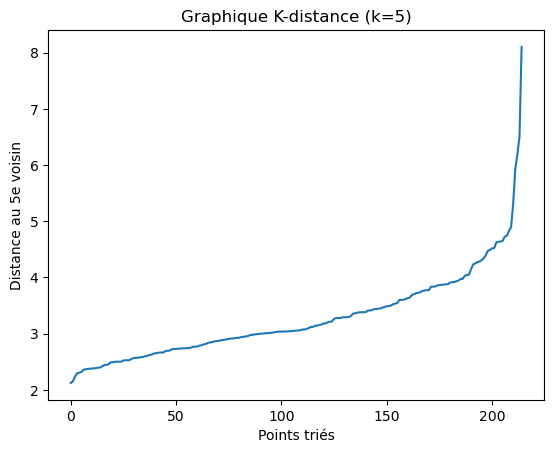

In [74]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)  # min_samples = 5
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# On trie les distances du 5e voisin
distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.title("Graphique K-distance (k=5)")
plt.ylabel("Distance au 5e voisin")
plt.xlabel("Points triés")
plt.show()


In [81]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

for eps in [0.3, 0.5, 0.7, 1.0, 1.5, 2, 5]:
    for ms in [3, 5, 10]:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(X_scaled, labels)
            print(f"eps={eps}, min_samples={ms} -> {n_clusters} clusters, silhouette={score:.3f}")
        else:
            print(f"eps={eps}, min_samples={ms} -> {n_clusters} cluster")


eps=0.3, min_samples=3 -> 0 cluster
eps=0.3, min_samples=5 -> 0 cluster
eps=0.3, min_samples=10 -> 0 cluster
eps=0.5, min_samples=3 -> 0 cluster
eps=0.5, min_samples=5 -> 0 cluster
eps=0.5, min_samples=10 -> 0 cluster
eps=0.7, min_samples=3 -> 0 cluster
eps=0.7, min_samples=5 -> 0 cluster
eps=0.7, min_samples=10 -> 0 cluster
eps=1.0, min_samples=3 -> 0 cluster
eps=1.0, min_samples=5 -> 0 cluster
eps=1.0, min_samples=10 -> 0 cluster
eps=1.5, min_samples=3 -> 0 cluster
eps=1.5, min_samples=5 -> 0 cluster
eps=1.5, min_samples=10 -> 0 cluster
eps=2, min_samples=3 -> 4 clusters, silhouette=-0.246
eps=2, min_samples=5 -> 0 cluster
eps=2, min_samples=10 -> 0 cluster
eps=5, min_samples=3 -> 1 cluster
eps=5, min_samples=5 -> 1 cluster
eps=5, min_samples=10 -> 1 cluster


## Réduire la dimension avant DBSCAN

In [82]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=10).fit_transform(X_scaled)

# --- 2) DBSCAN clustering
dbscan = DBSCAN(eps=2, min_samples=3).fit(X_pca)
labels_db = dbscan.fit_predict(X_scaled)

# --- 3) Afficher combien de clusters trouvés
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = list(labels_db).count(-1)
print(f"DBSCAN a trouvé {n_clusters} clusters et {n_noise} points considérés comme bruit (-1).")

# --- 4) Réalignement clusters -> vraies classes (majorité vote)
labels_aligned = np.zeros_like(labels_db)
for i in set(labels_db):
    if i == -1:  # bruit
        continue
    mask = (labels_db == i)
    if np.any(mask):
        labels_aligned[mask] = mode(y[mask], keepdims=True).mode[0]

DBSCAN a trouvé 4 clusters et 200 points considérés comme bruit (-1).


In [83]:
# --- 5) Évaluation
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y, labels_aligned))

print("\n=== Classification Report ===")
print(classification_report(y, labels_aligned))


=== Confusion Matrix ===
[[114   1]
 [ 91   9]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       115
           5       0.90      0.09      0.16       100

    accuracy                           0.57       215
   macro avg       0.73      0.54      0.44       215
weighted avg       0.72      0.57      0.46       215



# ----- MLPClassifier ----

In [61]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

In [62]:
# --- 2) Pipeline: StandardScaler + MLP
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-3,             # régularisation L2
        learning_rate_init=1e-3,
        early_stopping=True,    # stop auto si pas d'amélioration
        n_iter_no_change=15,
        max_iter=1000,
        random_state=42
    ))
])

# --- 3) (Optionnel) pondération pour déséquilibre
# calcule un poids par échantillon pour compenser les classes rares
sample_w = compute_sample_weight(class_weight="balanced", y=y_train)

# --- 4) Entraînement
mlp_pipe.fit(X_train, y_train, clf__sample_weight=sample_w)

In [65]:
# --- 5) Évaluation sur le test set
y_pred = mlp_pipe.predict(X_test)
print("Accuracy (test):", round(accuracy_score(y_test, y_pred), 4))
print("\n=== Classification report ===")
print(classification_report(y_test, y_pred))

Accuracy (test): 0.6818

=== Classification report ===
              precision    recall  f1-score   support

           0       0.85      0.69      0.76        16
           5       0.44      0.67      0.53         6

    accuracy                           0.68        22
   macro avg       0.65      0.68      0.65        22
weighted avg       0.74      0.68      0.70        22



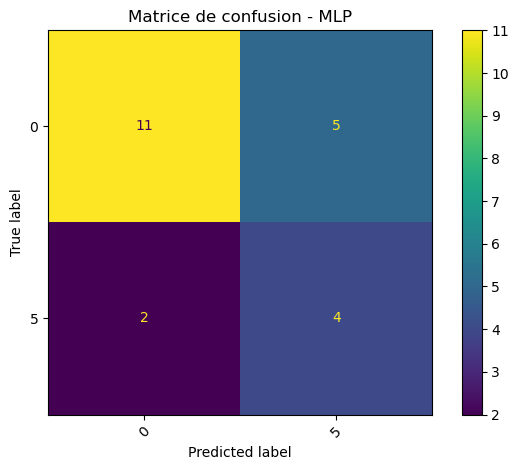

In [66]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(xticks_rotation=45)
plt.title("Matrice de confusion - MLP")
plt.tight_layout()
plt.show()

In [67]:
# --- 6) (Optionnel) Validation croisée macro-F1 pour une vue plus robuste
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    mlp_pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1
)
print("\nF1-macro CV (5-fold):", cv_scores.round(3), " | Moyenne:", round(cv_scores.mean(), 3))


F1-macro CV (5-fold): [0.697 0.761 0.88  0.666 0.813]  | Moyenne: 0.763


## Cercle inscrit

In [ ]:
import numpy as np
import cv2

# ------------------------------------------------------------
# 1) Nettoyage du masque: binaire {0,1}, plus grande composante,
#    crop sur la boîte englobante pour accélérer.
# ------------------------------------------------------------
def clean_mask(mask: np.ndarray):
    """
    mask: np.ndarray 2D, valeurs {0,1} ou {0,255}
    return:
      m_crop: masque binaire nettoyé (0/1) recadré sur la bbox
      bbox: (y0, x0, h, w) dans les coords du masque d'origine
    """
    m = (mask > 0).astype(np.uint8)

    if m.sum() == 0:
        # rien dans le masque -> renvoyer tel quel
        h, w = m.shape
        return m, (0, 0, h, w)

    # Composantes connexes et sélection de la plus grande
    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1:
        # une seule composante (label=0 = fond)
        largest = (m > 0)
    else:
        areas = stats[1:, cv2.CC_STAT_AREA]   # ignorer le fond
        idx = 1 + np.argmax(areas)
        largest = (labels == idx)

    largest = largest.astype(np.uint8)

    # BBox de la composante principale
    ys, xs = np.where(largest)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    m_crop = largest[y0:y1, x0:x1].astype(np.uint8)
    return m_crop, (int(y0), int(x0), int(y1 - y0), int(x1 - x0))


# ------------------------------------------------------------
# 2) Cercle inscrit max (méthode rapide via transformée de distance)
#    Option: raffinement du centre par optimisation (si SciPy dispo)
# ------------------------------------------------------------
def _bilinear_sample(img, y, x):
    """Échantillonnage bilinéaire img[y,x] pour y,x float (utilisé par le raffinement)."""
    h, w = img.shape
    if not (0 <= x < w-1 and 0 <= y < h-1):
        return 0.0
    x0, y0 = int(np.floor(x)), int(np.floor(y))
    x1, y1 = x0 + 1, y0 + 1
    dx, dy = x - x0, y - y0
    v00 = img[y0, x0]; v01 = img[y0, x1]
    v10 = img[y1, x0]; v11 = img[y1, x1]
    return float((1-dx)*(1-dy)*v00 + dx*(1-dy)*v01 + (1-dx)*dy*v10 + dx*dy*v11)

def largest_inscribed_circle(mask: np.ndarray, refine=False):
    """
    Calcule le plus grand cercle inscriptible dans le masque.
    mask: 2D binaire {0,1} ou {0,255}
    refine: True -> raffinement du centre avec scipy.optimize.minimize (si disponible)
    return:
      (cy, cx), r, info
      où (cy,cx) sont en coordonnées du masque d'origine (float), r en pixels
      info: dict (bbox, method, success, etc.)
    """
    # 1) Nettoyage + crop
    m_crop, (y0, x0, h, w) = clean_mask(mask)
    if m_crop.sum() == 0:
        return (np.nan, np.nan), 0.0, {"method": "none", "success": False, "reason": "empty mask"}

    # 2) Transformée de distance (OpenCV attend 0=fond, >0=foreground)
    #    La distance retournée ~ rayon max jusqu'au fond le plus proche.
    dist = cv2.distanceTransform(m_crop.astype(np.uint8), distanceType=cv2.DIST_L2, maskSize=5)

    # 3) Centre initial = argmax de la distance + rayon initial
    y_i, x_i = np.unravel_index(np.argmax(dist), dist.shape)
    r_i = float(dist[y_i, x_i])

    # Coordonnées dans le masque d'origine
    cy, cx = y0 + y_i, x0 + x_i
    r = r_i

    info = {"bbox": (y0, x0, h, w), "method": "edt", "success": True}

    if not refine:
        return (float(cy), float(cx)), float(r), info

    # 4) Raffinement par optimisation (optionnel)
    try:
        from scipy.optimize import minimize
        # centroid comme point de départ raisonnable (proche du corps)
        M = cv2.moments(m_crop.astype(np.uint8))
        if M["m00"] > 0:
            cy0 = M["m01"]/M["m00"]
            cx0 = M["m10"]/M["m00"]
        else:
            cy0, cx0 = float(y_i), float(x_i)

        # On maximise la distance: min de la loss = -dist interpolée
        def neg_dist(v):
            yy, xx = v
            return -_bilinear_sample(dist, yy, xx)

        bounds = [(0, h-1-1e-6), (0, w-1-1e-6)]
        res = minimize(neg_dist, x0=np.array([cy0, cx0], dtype=float),
                       bounds=bounds, method="L-BFGS-B")

        if res.success:
            cy_ref, cx_ref = res.x
            r_ref = _bilinear_sample(dist, cy_ref, cx_ref)
            if r_ref >= r:  # accepter si mieux
                cy, cx, r = y0 + cy_ref, x0 + cx_ref, r_ref
                info.update({"method": "edt+opt", "opt_success": True})
            else:
                info.update({"method": "edt (kept)", "opt_success": True})
        else:
            info.update({"method": "edt (opt_failed)", "opt_success": False})
    except Exception as e:
        # SciPy absent ou optimisation impossible : garder solution EDT
        info.update({"method": "edt (no_scipy)", "opt_success": False, "error": str(e)})

    return (float(cy), float(cx)), float(r), info


# ------------------------------------------------------------
# 3) Utilitaire d'affichage (overlay)
# ------------------------------------------------------------
def draw_inscribed_circle(image_rgb: np.ndarray, center, radius, thickness=2):
    """
    Retourne une copie de l'image avec le cercle tracé.
    image_rgb: HxWx3 (RGB)
    center: (cy, cx)
    radius: float
    """
    out = image_rgb.copy()
    cy, cx = center
    # OpenCV attend BGR -> convert rapide
    out_bgr = out[:, :, ::-1].copy()
    cv2.circle(out_bgr, (int(round(cx)), int(round(cy))), int(round(radius)),
               (0, 255, 0), thickness=thickness)  # vert (BGR)
    return out_bgr[:, :, ::-1]


# ---------------------------- EXEMPLE D'USAGE ----------------------------
# msk = load_mask(Path("..."))  # msk binaire 0/1
# (cy, cx), r, info = largest_inscribed_circle(msk, refine=True)
# print((cy, cx), r, info)
# img = load_image(Path("..."))
# vis = draw_inscribed_circle(img, (cy, cx), r)
# plt.imshow(vis); plt.axis('off'); plt.show()


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

# 1) Dossier des masques
MASKS_DIR = Path("../data/masks")   # adapte le chemin si ton notebook est dans notebooks/

# 2) Charger un masque (exemple: le premier)
mask_path = sorted(MASKS_DIR.glob("*.tif"))[0]   # ou [10] pour le 11ᵉ fichier, etc.
print("Mask choisi:", mask_path)

mask = load_mask(mask_path)  # tu as déjà load_mask dans ton src/dataio.py

# 3) Calcul du cercle inscrit
(center_yx, radius, info) = largest_inscribed_circle(mask, refine=True)
print("Centre:", center_yx, " Rayon:", radius)
print("Info:", info)

# 4) Visualisation
# img_path = Path(str(mask_path).replace("masks", "images")).with_suffix(".jpg")  
img_path = Path("../data/images/1.JPG")  # chemin direct pour tester
# ⚠️ adapte si tes images sont .JPG ou .png
img = load_image(img_path)

vis = draw_inscribed_circle(img, center_yx, radius)
plt.imshow(vis)
plt.title(f"{mask_path.name} - cercle inscrit")
plt.axis("off")
plt.show()


# -----------------------------

# 2. viz_models

# -----------------------------